<h1> Loading the Data </h1>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

#PS: Pressure, bar, 100 Hz --> 100 Messungen pro Sekunde
#EPS: Motor power, W, 100 Hz 
#FS: Volume flow, l/min, 10 Hz --> 10 Messungen pro Sekunde
#TS: Temperature, Celsius, 1 Hz --> 1 Messung pro Sekunde
#VS: Vibration, mm/s, 1Hz
#CE: Cooling efficiency (virtual), %, 1 Hz
#CP: Cooling power (virtual), kW, 1 Hz
#SE: Efficency factor, %, 1 Hz


class DataProcessor:
    def __init__(self, input_path, file_names):
        self.input_path = input_path
        self.file_names = file_names
        
    def read_files(self):
        self.data = {}
        print("Reading files...")
        for file in self.file_names:
            with open(self.input_path + file + '.txt', 'r') as f:
                self.data[file] = pd.read_csv(f, header=None, sep='\t')
        return self.data
    
    def print_shape(self):
        print("Files read:")
        for file in self.data:
            print(f"{file}: {self.data[file].shape}")
            
    def create_target_df(self):
        target_columns = ['Cooler_Condition', 'Valve_Condition', 
                        'Internal_Pump_Leakage', 'Hydraulic_Accumulator', 
                        'Stable_Flag']
        self.data['target'].columns = target_columns
        self.valve_condition = self.data['target']['Valve_Condition']
        #del self.data['target']
        return self.valve_condition

def process_data():
    input_path = "input_data/"
    file_names = [
        "ce", "cp", "eps1", "se", "vs1", 
        "fs1", "fs2", 
        "ps1", "ps2", "ps3", "ps4", "ps5", "ps6",
        "ts1", "ts2", "ts3", "ts4", "target"
    ]
    
    processor = DataProcessor(input_path, file_names)
    data = processor.read_files()
    processor.print_shape()
    df_target = processor.create_target_df()
    df_target = processor.valve_condition
    return data, df_target

data, df_target = process_data()

Reading files...
Files read:
ce: (2205, 60)
cp: (2205, 60)
eps1: (2205, 6000)
se: (2205, 60)
vs1: (2205, 60)
fs1: (2205, 600)
fs2: (2205, 600)
ps1: (2205, 6000)
ps2: (2205, 6000)
ps3: (2205, 6000)
ps4: (2205, 6000)
ps5: (2205, 6000)
ps6: (2205, 6000)
ts1: (2205, 60)
ts2: (2205, 60)
ts3: (2205, 60)
ts4: (2205, 60)
target: (2205, 5)


<h1> 1. Data Exploration </h1>

<h2>CE sensor (1 Hz) </h2>

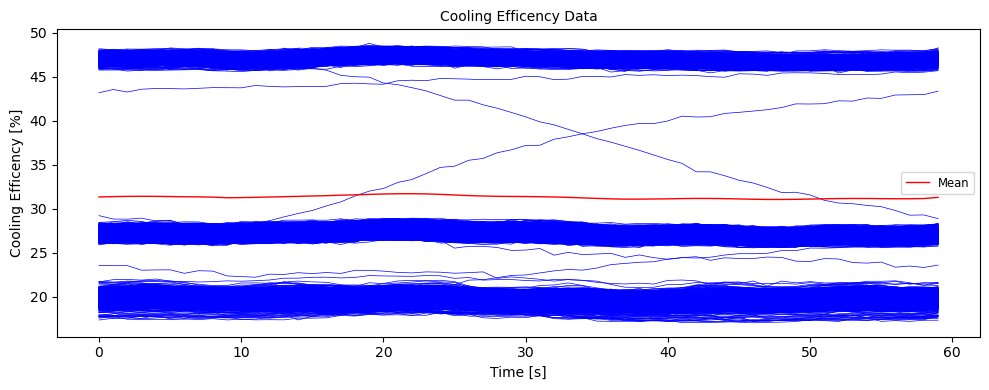

In [2]:
fig, ax = plt.subplots(figsize=(10, 4), dpi=100)

for i in range(data['ce'].shape[0] - 1):
    ax.plot(data['ce'].iloc[i], color='blue', linewidth=0.5)

ax.plot(data['ce'].mean(axis=0), color='red', linewidth=1, label='Mean')

ax.set_title('Cooling Efficency Data', fontsize=10)
plt.xlabel("Time [s]")
plt.ylabel("Cooling Efficency [%]")
plt.legend(loc='best', fontsize='small')
plt.tight_layout()
plt.show()

<h3>CE Sensor - FFT Plot</h3>

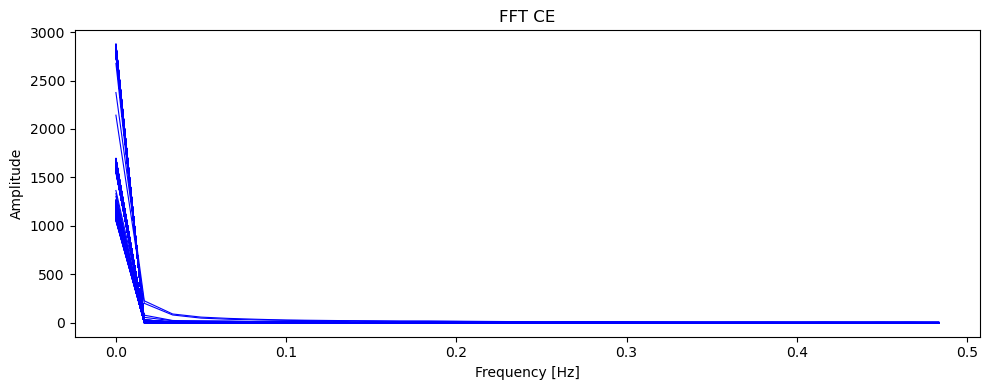

In [3]:
sampling_rate = 1  # 1 Hz

fig, ax = plt.subplots(figsize=(10, 4), dpi=100)

for i in range(data['ce'].shape[0]):
    row = data['ce'].iloc[i].values
    fft_values = np.fft.fft(row)
    frequencies = np.fft.fftfreq(len(row), d=1/sampling_rate)
  
    positive_frequencies = frequencies[:len(frequencies) // 2] # First half of the frequencies array contains the positive frequencies
    positive_fft_values = np.abs(fft_values[:len(fft_values) // 2]) # abs to ignore the phase information
    
    ax.plot(positive_frequencies, positive_fft_values, color = 'blue', linewidth=0.8)

ax.set_title('FFT CE', fontsize=12)
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Amplitude')
plt.tight_layout()
plt.show()


In [4]:
df_combined = pd.concat([data['ce'], df_target], axis=1)
mean_per_condition = (
    df_combined.drop(columns=['Valve_Condition'], axis=1) 
      .groupby(df_combined['Valve_Condition'])           
      .mean()                                
      .mean(axis=1)
    )                             
print(mean_per_condition)

Valve_Condition
73     31.319484
80     31.297182
90     31.358514
100    31.274134
dtype: float64


<h2>CP Sensor (1 Hz)</h2>

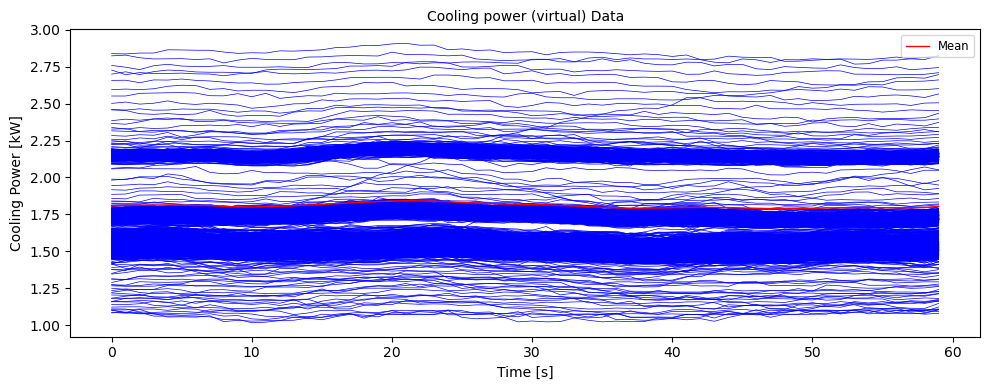

In [5]:
fig, ax = plt.subplots(figsize=(10, 4), dpi=100)

for i in range(data['cp'].shape[0] - 1):
    ax.plot(data['cp'].iloc[i], color='blue', linewidth=0.5)

ax.plot(data['cp'].mean(axis=0), color='red', linewidth=1, label='Mean')

ax.set_title('Cooling power (virtual) Data', fontsize=10)
plt.xlabel("Time [s]")
plt.ylabel("Cooling Power [kW]")
plt.legend(loc='best', fontsize='small')
plt.tight_layout()
plt.show()

<h3> CP Sensor - FFT plot </h3>

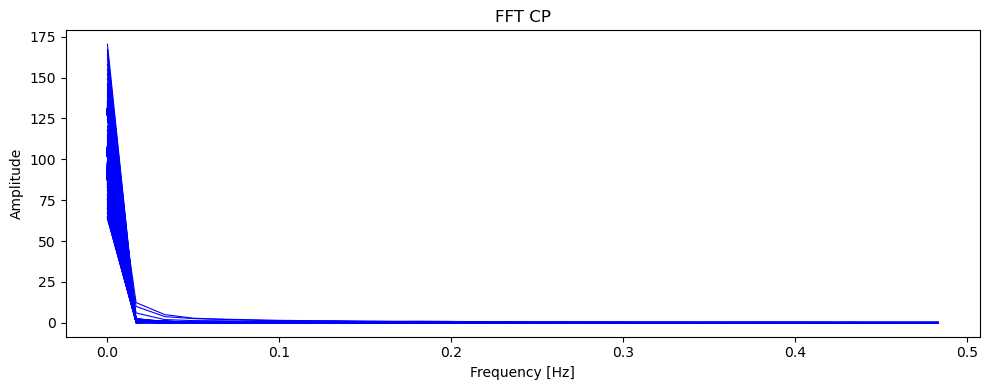

In [6]:
sampling_rate = 1  # 1 Hz

fig, ax = plt.subplots(figsize=(10, 4), dpi=100)

for i in range(data['cp'].shape[0]):
    row = data['cp'].iloc[i].values
    fft_values = np.fft.fft(row)
    frequencies = np.fft.fftfreq(len(row), d=1/sampling_rate)
  
    positive_frequencies = frequencies[:len(frequencies) // 2] # First half of the frequencies array contains the positive frequencies
    positive_fft_values = np.abs(fft_values[:len(fft_values) // 2]) # abs to ignore the phase information
    
    ax.plot(positive_frequencies, positive_fft_values, color = 'blue', linewidth=0.8)

ax.set_title('FFT CP', fontsize=12)
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Amplitude')
plt.tight_layout()
plt.show()


In [7]:
df_combined = pd.concat([data['cp'], df_target], axis=1)
mean_per_condition = (
    df_combined.drop(columns=['Valve_Condition'], axis=1) 
      .groupby(df_combined['Valve_Condition'])           
      .mean()                                
      .mean(axis=1)
    )                             
print(mean_per_condition)

Valve_Condition
73     1.805034
80     1.805221
90     1.808178
100    1.810562
dtype: float64


<h2>VS Sensor (1 Hz)</h2>

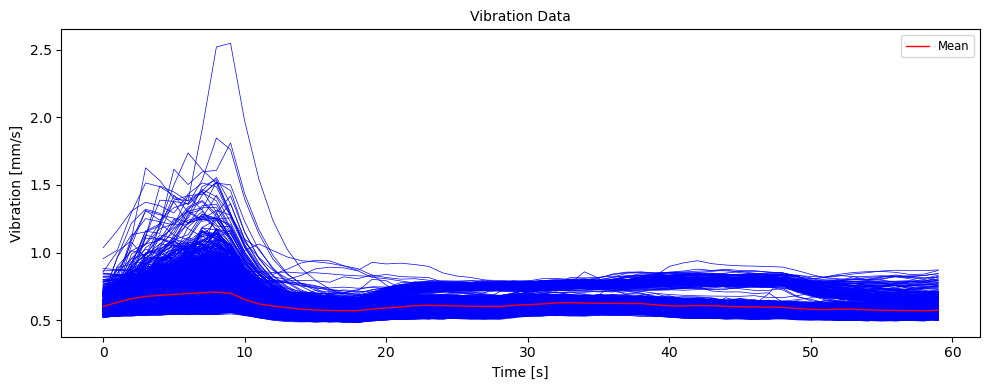

In [8]:
fig, ax = plt.subplots(figsize=(10, 4), dpi=100)

for i in range(data['vs1'].shape[0] - 1):
    ax.plot(data['vs1'].iloc[i], color='blue', linewidth=0.5)

ax.plot(data['vs1'].mean(axis=0), color='red', linewidth=1, label='Mean')

ax.set_title('Vibration Data', fontsize=10)
plt.xlabel("Time [s]")
plt.ylabel("Vibration [mm/s]")
plt.legend(loc='best', fontsize='small')
plt.tight_layout()
plt.show()

<h3>VS Sensor - FFT Plot</h3>

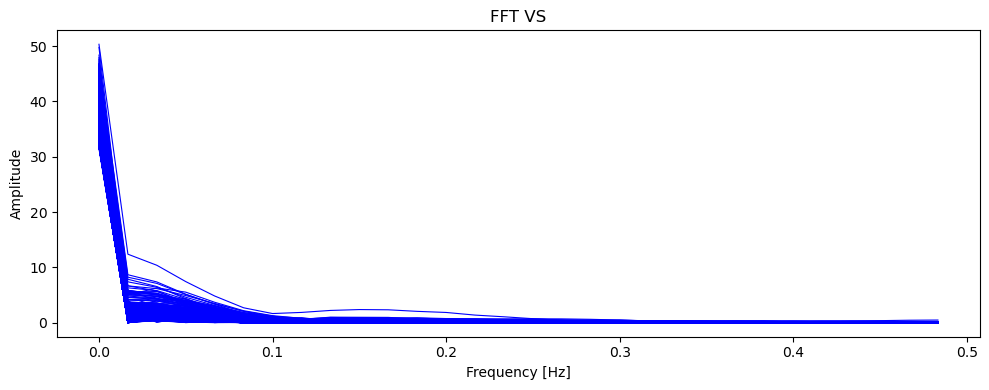

In [9]:
sampling_rate = 1  # 1 Hz

fig, ax = plt.subplots(figsize=(10, 4), dpi=100)

for i in range(data['vs1'].shape[0]):
    row = data['vs1'].iloc[i].values
    fft_values = np.fft.fft(row)
    frequencies = np.fft.fftfreq(len(row), d=1/sampling_rate)
  
    positive_frequencies = frequencies[:len(frequencies) // 2] # First half of the frequencies array contains the positive frequencies
    positive_fft_values = np.abs(fft_values[:len(fft_values) // 2]) # abs to ignore the phase information
    
    ax.plot(positive_frequencies, positive_fft_values, color = 'blue', linewidth=0.8)

ax.set_title('FFT VS', fontsize=12)
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Amplitude')
plt.tight_layout()
plt.show()


In [10]:
df_combined = pd.concat([data['vs1'], df_target], axis=1)
mean_per_condition = (
    df_combined.drop(columns=['Valve_Condition'], axis=1) 
      .groupby(df_combined['Valve_Condition'])           
      .mean()                                
      .mean(axis=1)
    )                             
print(mean_per_condition)

Valve_Condition
73     0.623013
80     0.619320
90     0.616718
100    0.607202
dtype: float64


In [11]:
#Ausreiser entfernen
remove_row = data['vs1'][np.any(data['vs1'].values > 2.0, axis=1)]
data['vs1'] = data['vs1'].drop(remove_row.index)

<h2>SE Sensor (1 Hz)</h2>

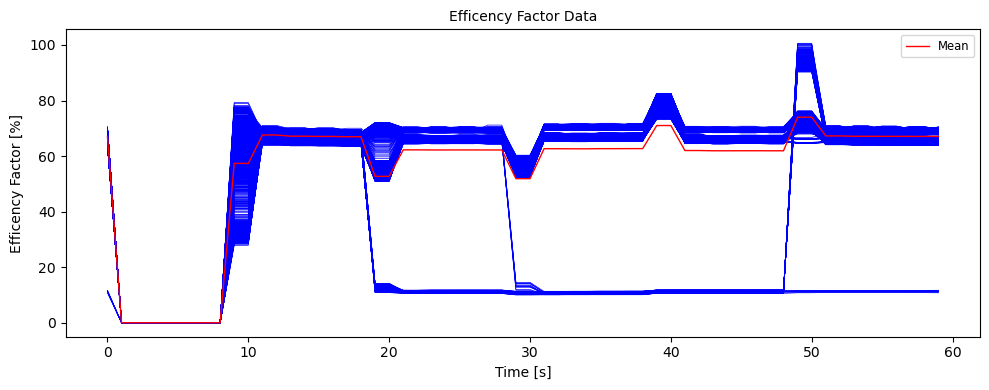

In [12]:
fig, ax = plt.subplots(figsize=(10, 4), dpi=100)

for i in range(data['se'].shape[0] - 1):
    ax.plot(data['se'].iloc[i], color='blue', linewidth=0.5)

ax.plot(data['se'].mean(axis=0), color='red', linewidth=1, label='Mean')

ax.set_title('Efficency Factor Data', fontsize=10)
plt.xlabel("Time [s]")
plt.ylabel("Efficency Factor [%]")
plt.legend(loc='best', fontsize='small')
plt.tight_layout()
plt.show()

<h3>SE Sensor - FFT Plot</h3>

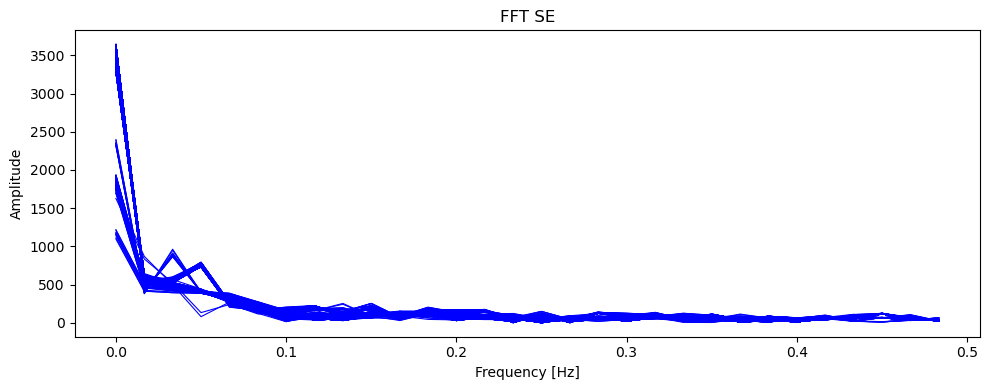

In [13]:
sampling_rate = 1  # 1 Hz

fig, ax = plt.subplots(figsize=(10, 4), dpi=100)

for i in range(data['se'].shape[0]):
    row = data['se'].iloc[i].values
    fft_values = np.fft.fft(row)
    frequencies = np.fft.fftfreq(len(row), d=1/sampling_rate)
  
    positive_frequencies = frequencies[:len(frequencies) // 2] # First half of the frequencies array contains the positive frequencies
    positive_fft_values = np.abs(fft_values[:len(fft_values) // 2]) # abs to ignore the phase information
    
    ax.plot(positive_frequencies, positive_fft_values, color = 'blue', linewidth=0.8)

ax.set_title('FFT SE', fontsize=12)
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Amplitude')
plt.tight_layout()
plt.show()


In [14]:
df_combined = pd.concat([data['se'], df_target], axis=1)
mean_per_condition = (
    df_combined.drop(columns=['Valve_Condition'], axis=1) 
      .groupby(df_combined['Valve_Condition'])           
      .mean()                                
      .mean(axis=1)
    )                             
print(mean_per_condition)

Valve_Condition
73     52.441894
80     53.263315
90     53.464748
100    57.429897
dtype: float64


<h2>TS Sensors (1 Hz)</h2>

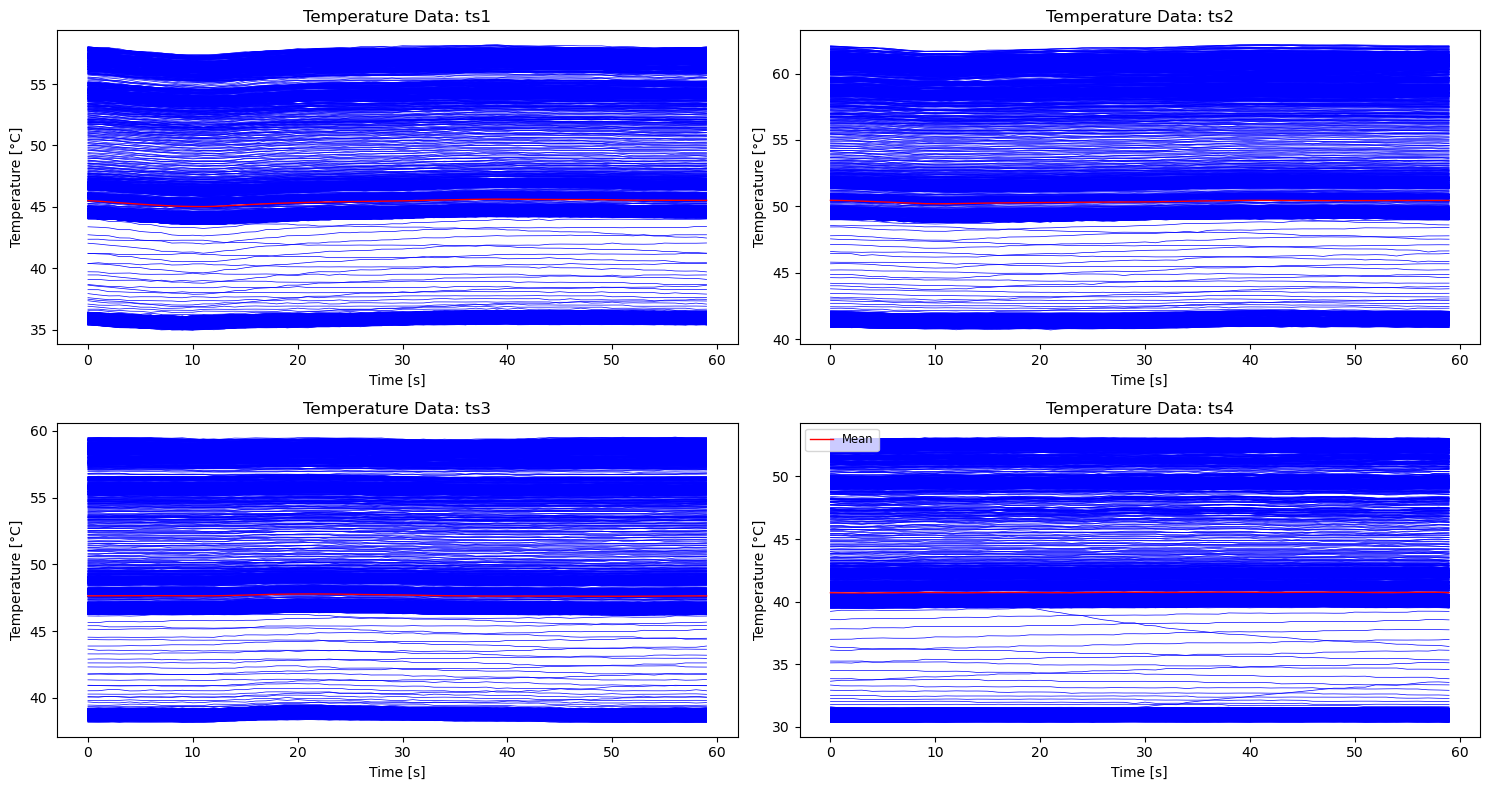

In [15]:
temp_sensors = ['ts1', 'ts2', 'ts3', 'ts4']

fig, axes = plt.subplots(2, 2, figsize=(15, 8), dpi=100)
axes = axes.flatten()

for idx, s in enumerate(temp_sensors):
    ax = axes[idx]
    for i in range(data[s].shape[0]-1):
        ax.plot(data[s].iloc[i], color='blue', linewidth=0.5)
    ax.plot(data[s].mean(axis=0), color='red', linewidth=1, label = 'Mean')
    
    ax.set_title(f"Temperature Data: {s}")
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Temperature [°C]")
    
plt.legend(loc='best', fontsize='small')
plt.tight_layout()
plt.show()

<h3>TS Sensors - FFT Plots</h3>

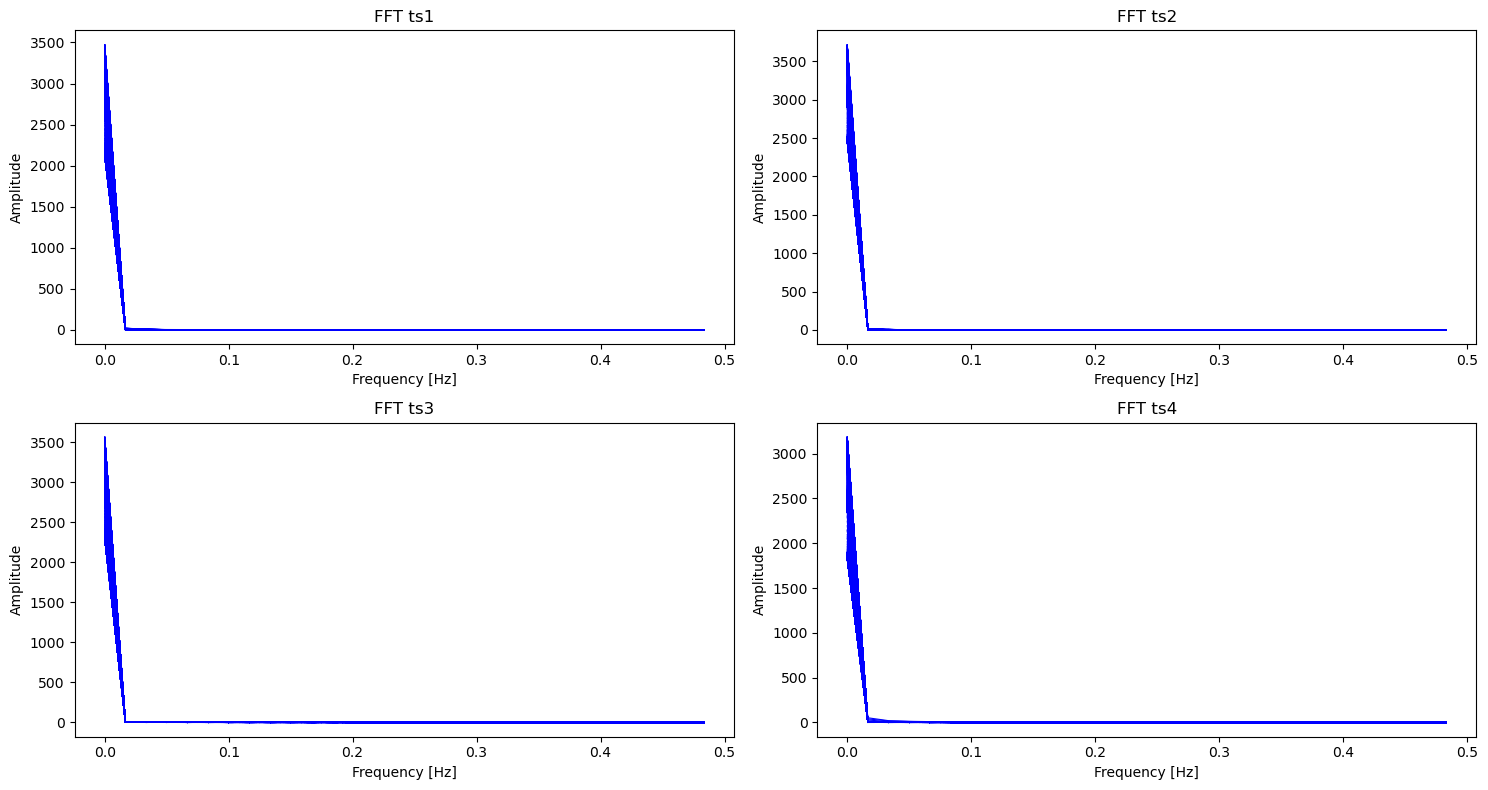

In [16]:
sampling_rate = 1  # 1 Hz

fig, axes = plt.subplots(2, 2, figsize=(15, 8), dpi=100)
axes = axes.flatten()

for idx, s in enumerate(temp_sensors):
    ax = axes[idx]
    
    for i in range(data[s].shape[0] - 1):
        row = data[s].iloc[i].values
        
        fft_values = np.fft.fft(row)
        frequencies = np.fft.fftfreq(len(row), d=1/sampling_rate)
    
        positive_frequencies = frequencies[:len(frequencies) // 2] # First half of the frequencies array contains the positive frequencies
        positive_fft_values = np.abs(fft_values[:len(fft_values) // 2]) # abs to ignore the phase information
        
        ax.plot(positive_frequencies, positive_fft_values, color = 'blue', linewidth=0.8)
        
        ax.set_title(f'FFT {s}', fontsize=12)
        ax.set_xlabel('Frequency [Hz]')
        ax.set_ylabel('Amplitude')
        
plt.tight_layout()
plt.show()


In [17]:
for s in temp_sensors:
    df_combined = pd.concat([data[s], df_target], axis=1)
    mean_per_condition = (
        df_combined.drop(columns=['Valve_Condition'], axis=1) 
          .groupby(df_combined['Valve_Condition'])           
          .mean()                                
          .mean(axis=1)
        )
    print(s + ':')                             
    print(mean_per_condition)

ts1:
Valve_Condition
73     45.629744
80     45.647847
90     45.671871
100    45.208323
dtype: float64
ts2:
Valve_Condition
73     50.500104
80     50.512613
90     50.525565
100    50.225068
dtype: float64
ts3:
Valve_Condition
73     47.857446
80     47.880050
90     47.901773
100    47.453192
dtype: float64
ts4:
Valve_Condition
73     40.933590
80     40.954339
90     40.961833
100    40.529958
dtype: float64


<h2>FS Sensors (10 Hz)</h2>

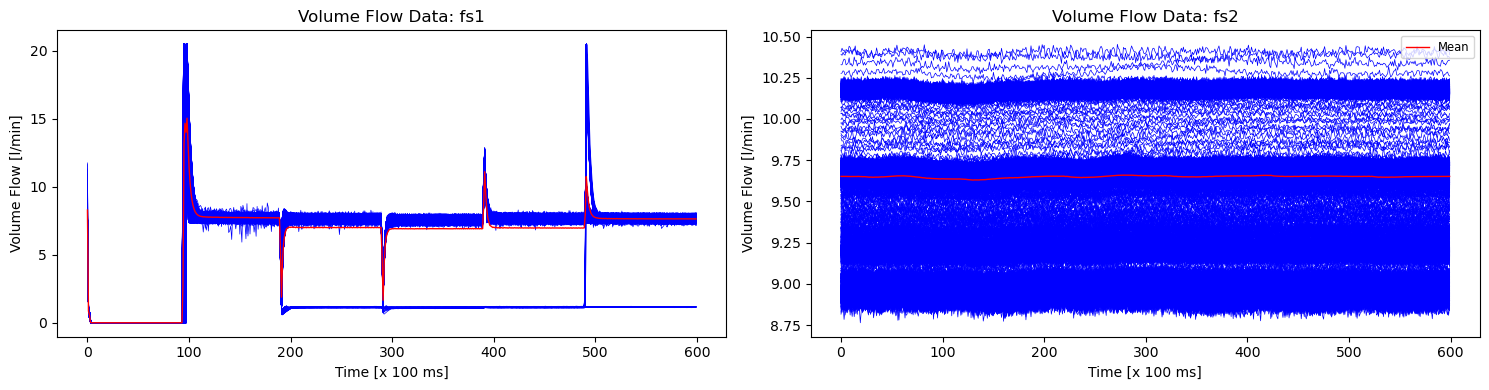

In [18]:
vf_sensors = ['fs1', 'fs2']

fig, axes = plt.subplots(1, 2, figsize=(15, 4), dpi=100)
axes = axes.flatten()

for idx, s in enumerate(vf_sensors):
    ax = axes[idx]
    for i in range(data[s].shape[0] - 1):
        ax.plot(data[s].iloc[i], color='blue', linewidth=0.5)
    ax.plot(data[s].mean(axis=0), color='red', linewidth=1, label='Mean')
    
    ax.set_title(f"Volume Flow Data: {s}")
    ax.set_xlabel("Time [x 100 ms]")
    ax.set_ylabel("Volume Flow [l/min]")
    
plt.legend(loc='best', fontsize='small')
plt.tight_layout()
plt.show()

<h3>FS Sensors - FFT Plots </h3>

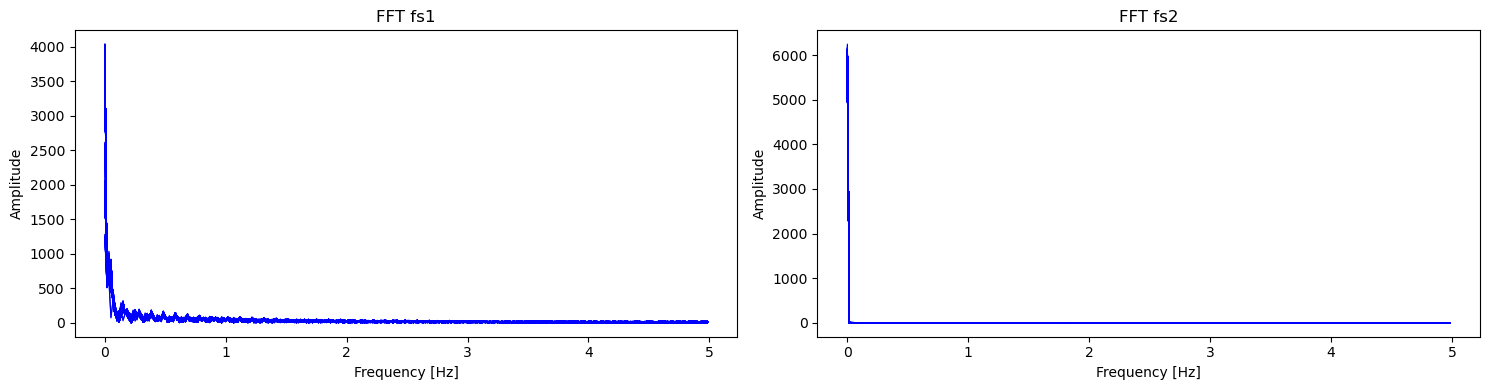

In [19]:
sampling_rate = 10  # 10 Hz

fig, axes = plt.subplots(1, 2, figsize=(15, 4), dpi=100)
axes = axes.flatten()

for idx, s in enumerate(vf_sensors):
    ax = axes[idx]
    
    for i in range(data[s].shape[0] - 1):
        row = data[s].iloc[i].values
        
        fft_values = np.fft.fft(row)
        frequencies = np.fft.fftfreq(len(row), d=1/sampling_rate)
    
        positive_frequencies = frequencies[:len(frequencies) // 2] # First half of the frequencies array contains the positive frequencies
        positive_fft_values = np.abs(fft_values[:len(fft_values) // 2]) # abs to ignore the phase information
        
        ax.plot(positive_frequencies, positive_fft_values, color = 'blue', linewidth=0.8)
        
        ax.set_title(f'FFT {s}', fontsize=12)
        ax.set_xlabel('Frequency [Hz]')
        ax.set_ylabel('Amplitude')
        
plt.tight_layout()
plt.show()


In [20]:
for s in vf_sensors:
    df_combined = pd.concat([data[s], df_target], axis=1)
    mean_per_condition = (
        df_combined.drop(columns=['Valve_Condition'], axis=1) 
          .groupby(df_combined['Valve_Condition'])           
          .mean()                                
          .mean(axis=1)
        )
    print(s + ':')                             
    print(mean_per_condition)

fs1:
Valve_Condition
73     5.951552
80     5.993925
90     5.990347
100    6.409693
dtype: float64
fs2:
Valve_Condition
73     9.631467
80     9.628707
90     9.625955
100    9.669367
dtype: float64


<h2>EPS Sensor (100 Hz)</h2>

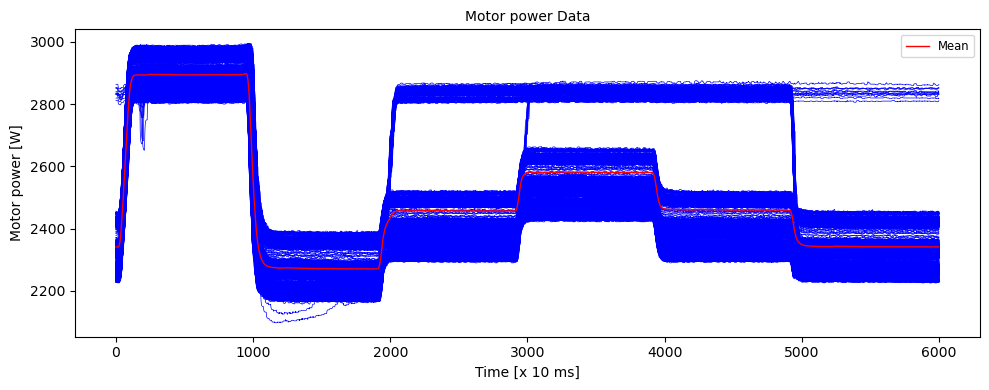

In [21]:
fig, ax = plt.subplots(figsize=(10, 4), dpi=100)
for i in range(data['eps1'].shape[0] - 1):
    ax.plot(data['eps1'].iloc[i], color='blue', linewidth=0.5)

ax.plot(data['eps1'].mean(axis=0), color='red', linewidth=1, label='Mean')

ax.set_title('Motor power Data', fontsize=10)
plt.xlabel("Time [x 10 ms]")
plt.ylabel("Motor power [W]")
plt.legend(loc='best', fontsize='small')

plt.tight_layout()
plt.show()

<h3>EPS Sensor - FFT Plot </h3>

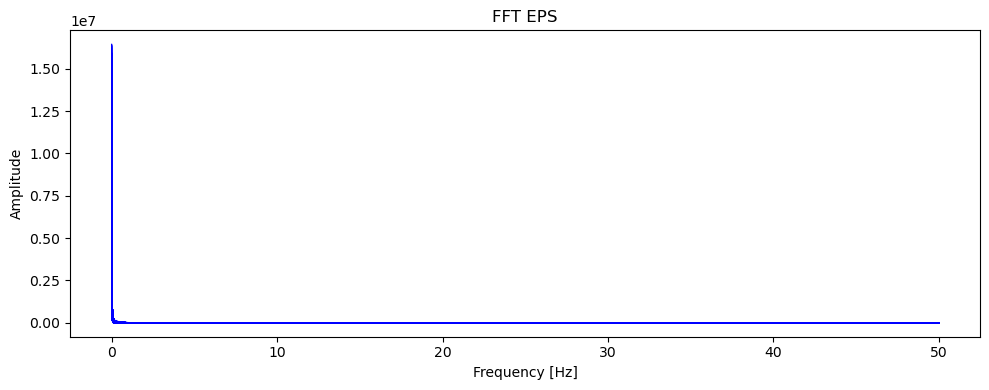

In [22]:
sampling_rate = 100  # 100 Hz

fig, ax = plt.subplots(figsize=(10, 4), dpi=100)

for i in range(data['eps1'].shape[0]):
    row = data['eps1'].iloc[i].values
    fft_values = np.fft.fft(row)
    frequencies = np.fft.fftfreq(len(row), d=1/sampling_rate)
  
    positive_frequencies = frequencies[:len(frequencies) // 2] # First half of the frequencies array contains the positive frequencies
    positive_fft_values = np.abs(fft_values[:len(fft_values) // 2]) # abs to ignore the phase information
    
    ax.plot(positive_frequencies, positive_fft_values, color = 'blue', linewidth=0.8)

ax.set_title('FFT EPS', fontsize=12)
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Amplitude')
plt.tight_layout()
plt.show()


In [23]:
df_combined = pd.concat([data['eps1'], df_target], axis=1)
mean_per_condition = (
    df_combined.drop(columns=['Valve_Condition'], axis=1) 
      .groupby(df_combined['Valve_Condition'])           
      .mean()                                
      .mean(axis=1)
    )                             
print(mean_per_condition)

Valve_Condition
73     2511.798536
80     2508.887079
90     2509.089291
100    2481.670067
dtype: float64


In [24]:
#Ausreiser entfernen
remove_row = data['eps1'][np.any(data['eps1'].values < 2150, axis=1)]
remove_row
data['eps1'] = data['eps1'].drop(remove_row.index)

<h2>PS Sensors (100 Hz)</h2>

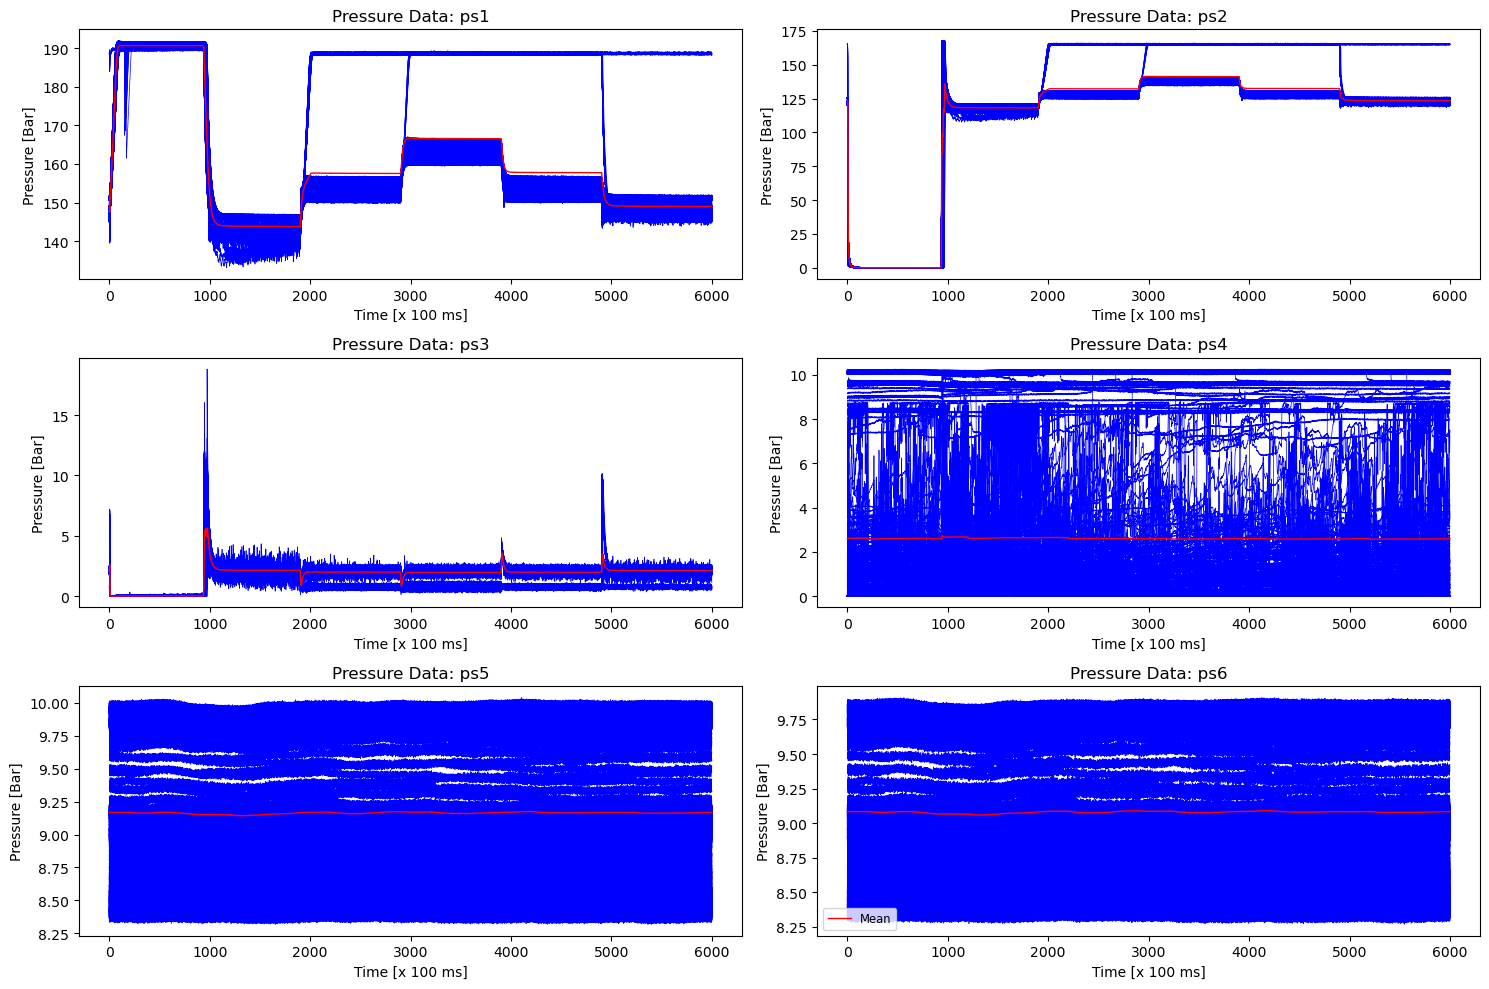

In [25]:
ps_sensors = ['ps1', 'ps2', 'ps3', 'ps4', 'ps5', 'ps6']

fig, axes = plt.subplots(3, 2, figsize=(15, 10), dpi=100)
axes = axes.flatten()

for idx, s in enumerate(ps_sensors):
    ax = axes[idx]
    
    # Nur jede 10. Spalte auswählen
    # reduced_data = data[s].iloc[:, ::10]
    
    for i in range(data[s].shape[0] - 1):
        ax.plot(data[s].iloc[i], color='blue', linewidth=0.5)
    
    ax.plot(data[s].mean(axis=0), color='red', linewidth=1, label = 'Mean')
    
    ax.set_title(f"Pressure Data: {s}")
    ax.set_xlabel("Time [x 100 ms]")
    ax.set_ylabel("Pressure [Bar]")
    
plt.legend(loc='best', fontsize='small')
plt.tight_layout()
plt.show()


<h3>PS Sensors - FFT Plots </h3>

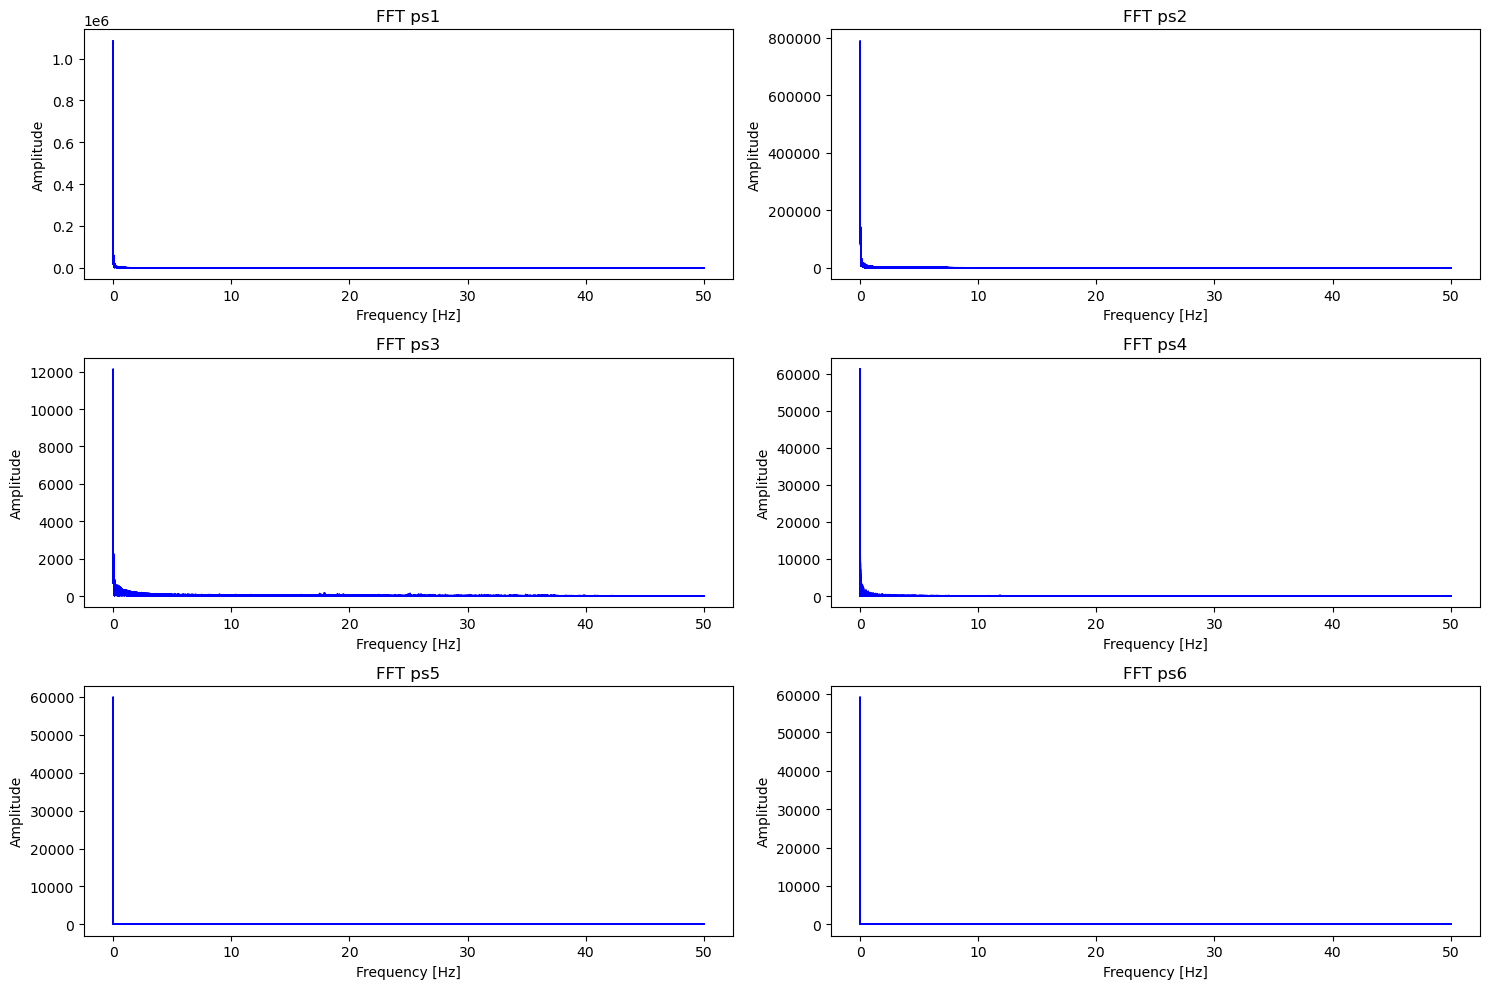

In [26]:
sampling_rate = 100  # 100 Hz

fig, axes = plt.subplots(3, 2, figsize=(15, 10), dpi=100)
axes = axes.flatten()

for idx, s in enumerate(ps_sensors):
    ax = axes[idx]
    
    for i in range(data[s].shape[0] - 1):
        row = data[s].iloc[i].values
        
        fft_values = np.fft.fft(row)
        frequencies = np.fft.fftfreq(len(row), d=1/sampling_rate)
    
        positive_frequencies = frequencies[:len(frequencies) // 2] # First half of the frequencies array contains the positive frequencies
        positive_fft_values = np.abs(fft_values[:len(fft_values) // 2]) # abs to ignore the phase information
        
        ax.plot(positive_frequencies, positive_fft_values, color = 'blue', linewidth=0.8)
        
        ax.set_title(f'FFT {s}', fontsize=12)
        ax.set_xlabel('Frequency [Hz]')
        ax.set_ylabel('Amplitude')
        
plt.tight_layout()
plt.show()


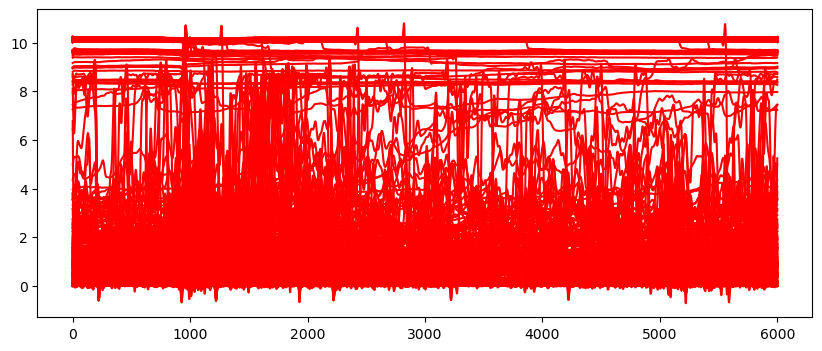

<Figure size 1000x500 with 0 Axes>

In [27]:
from scipy.signal import butter, filtfilt

# Definiere Cutoff-Frequenz
cutoff_frequency = 3
sampling_rate = 100 

fig, ax = plt.subplots(figsize=(10, 4), dpi=100)
plt.figure(figsize=(10, 5))
b, a = butter(N=4, Wn=cutoff_frequency/(sampling_rate/2), btype='low')
for i in range(data['ps4'].shape[0]):
    original_signal = data['ps4'].iloc[i].values
    filtered_signal = filtfilt(b, a, original_signal)
    ax.plot(filtered_signal, label='Filtered Signal (Low-pass)', color='red')
plt.show()



In [28]:
for s in ps_sensors:
    df_combined = pd.concat([data[s], df_target], axis=1)
    mean_per_condition = (
        df_combined.drop(columns=['Valve_Condition'], axis=1) 
          .groupby(df_combined['Valve_Condition'])           
          .mean()                                
          .mean(axis=1)
        )
    print(s + ':')                             
    print(mean_per_condition)

ps1:
Valve_Condition
73     161.408184
80     161.211482
90     161.239718
100    159.716214
dtype: float64
ps2:
Valve_Condition
73     109.810641
80     109.957396
90     110.273762
100    108.771240
dtype: float64
ps3:
Valve_Condition
73     1.702893
80     1.708117
90     1.710377
100    1.797482
dtype: float64
ps4:
Valve_Condition
73     3.422267
80     3.214646
90     3.248737
100    1.933113
dtype: float64
ps5:
Valve_Condition
73     9.150767
80     9.149400
90     9.148484
100    9.176539
dtype: float64
ps6:
Valve_Condition
73     9.067561
80     9.065915
90     9.065221
100    9.091968
dtype: float64


<h2> Valve Condition </h2>

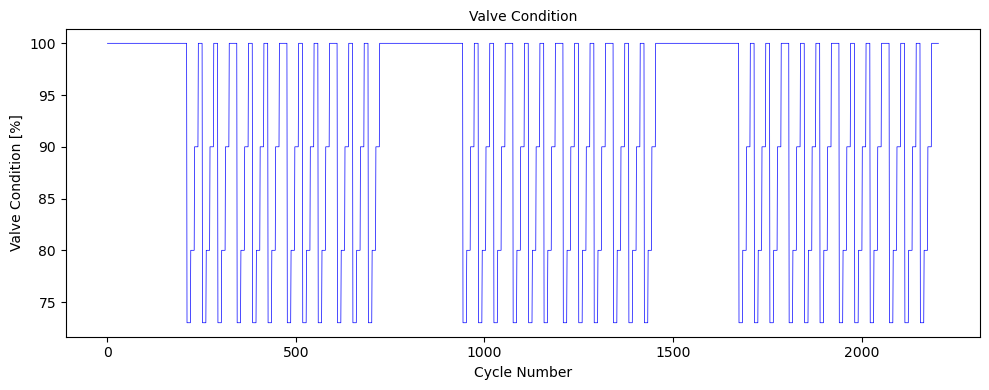

In [29]:
fig, ax = plt.subplots(figsize=(10, 4), dpi=100)

ax.plot(df_target, color='blue', linewidth=0.5)

ax.set_title('Valve Condition', fontsize=10)
plt.xlabel("Cycle Number")
plt.ylabel("Valve Condition [%]")


plt.tight_layout()
plt.show()

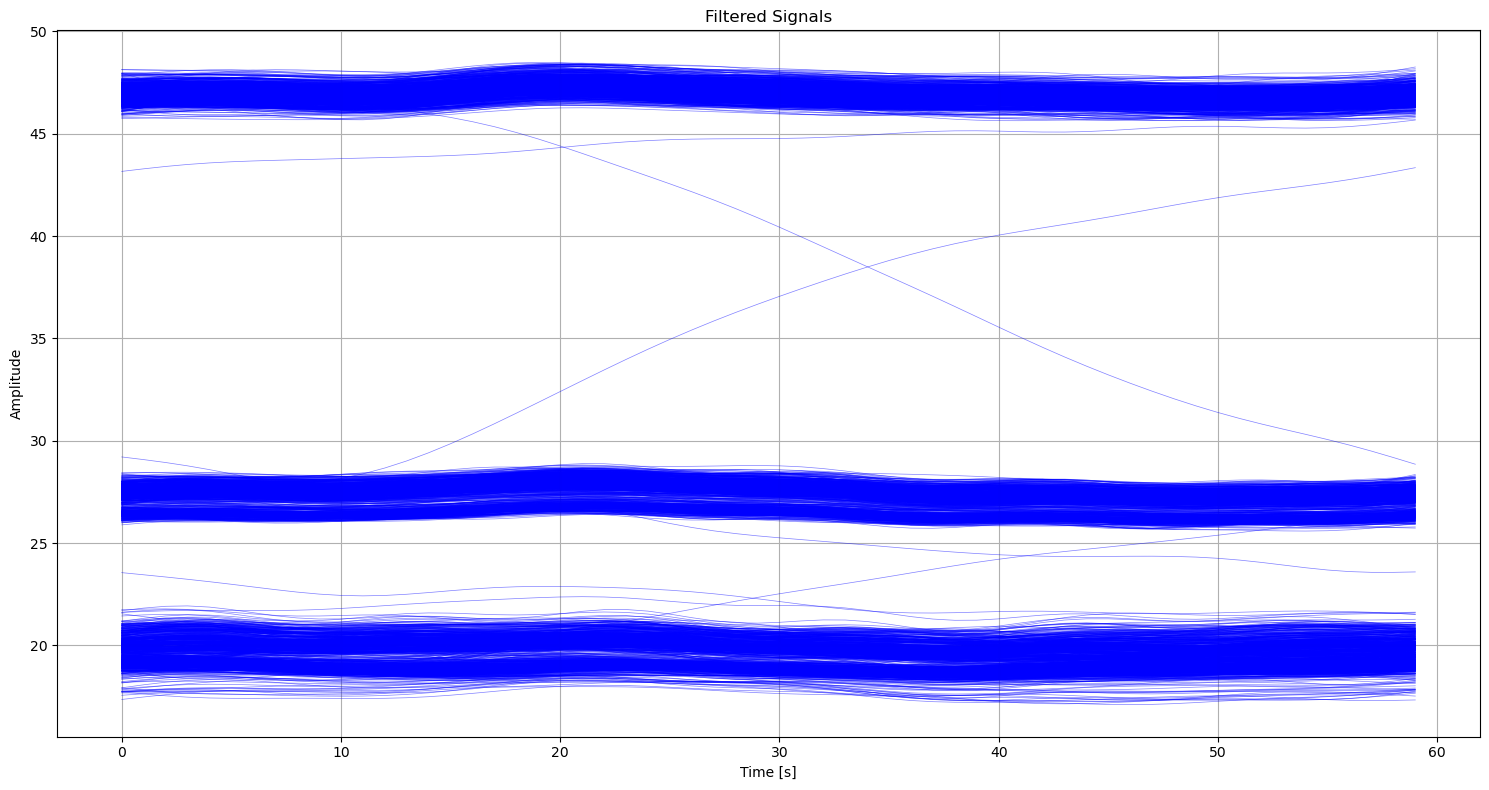

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# Define the Butterworth lowpass filter
def butter_lowpass(cutoff, fs, order):
    return signal.butter(order, cutoff, fs=fs, btype='low', analog=False)

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

# Parameters for the filter
order = 6        # Filter order
fs = 1         # Sampling frequency (Hz)
cutoff = 0.1   # Cutoff frequency (Hz)

# Apply Butterworth filter to each row
filtered_data = data['ce'].apply(lambda row: butter_lowpass_filter(row, cutoff, fs, order), axis=1)

# Plot all filtered signals in one graph
plt.figure(figsize=(15, 8))

for idx in range(filtered_data.shape[0]):
    plt.plot(filtered_data.iloc[idx], color = 'blue', alpha=0.5, linewidth=0.5)  # Adjust alpha and linewidth for better visualization

plt.title('Filtered Signals')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid(True)
plt.tight_layout()
plt.show()

In [31]:
data['ce']

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,47.202,47.273,47.250,47.332,47.213,47.372,47.273,47.438,46.691,46.599,...,31.554,30.953,30.639,30.561,30.368,30.224,29.790,29.261,29.287,28.866
1,29.208,28.822,28.805,28.922,28.591,28.643,28.216,27.812,27.514,27.481,...,23.995,24.328,24.283,23.877,23.816,23.933,23.354,23.483,23.320,23.588
2,23.554,23.521,23.527,23.008,23.042,23.052,22.658,22.952,22.908,22.359,...,21.711,21.564,21.564,21.526,21.753,21.749,21.802,21.582,21.283,21.519
3,21.540,21.419,21.565,20.857,21.052,21.039,20.926,20.912,20.989,20.882,...,20.687,20.703,20.295,20.482,20.600,20.547,20.708,20.708,20.574,20.403
4,20.460,20.298,20.350,19.867,19.997,19.972,19.924,19.813,19.691,19.634,...,19.887,19.919,19.696,19.634,19.747,20.005,19.919,19.736,19.977,20.016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2200,46.798,46.688,46.699,46.844,46.819,46.725,46.713,46.832,46.727,46.362,...,46.375,46.334,46.395,46.264,46.325,46.255,46.375,46.421,46.242,46.382
2201,46.477,46.525,46.013,46.349,46.345,46.286,46.156,46.406,46.188,45.762,...,46.529,46.770,46.649,46.565,46.532,46.521,46.615,46.603,46.710,46.729
2202,46.757,46.863,46.756,46.863,46.816,46.813,46.863,46.863,46.849,46.710,...,45.886,45.715,45.683,45.836,45.943,45.774,46.051,45.800,46.171,46.502
2203,46.584,46.469,46.538,46.538,46.477,46.432,46.491,46.514,46.539,46.432,...,46.640,46.181,46.351,46.723,46.699,46.579,46.687,46.590,46.579,46.570


In [34]:
filtered_data

0       [47.201610615753744, 47.26953259017005, 47.323...
1       [29.208301300148594, 29.07841298468181, 28.936...
2       [23.554423457848607, 23.44952162084628, 23.342...
3       [21.54216144812964, 21.404201851619607, 21.276...
4       [20.4621621479773, 20.35104114409441, 20.24270...
                              ...                        
2200    [46.80101588773114, 46.814608153038975, 46.822...
2201    [46.47577237684422, 46.42427506559567, 46.3750...
2202    [46.75680261507445, 46.79380633356293, 46.8264...
2203    [46.58178264437288, 46.55542725442261, 46.5368...
2204    [46.7693520777297, 46.714061588072916, 46.6631...
Length: 2205, dtype: object